# Key-value Memory Network (yyang)

# Introduction

Memory networks learn to access external memory stores (a database or, in the case of this assignment, a dictionary). Key-Value Memory Networks specifically assume that the external memory store is organized as a dictionary with keys and values. In theory memory networks are useful when one wants a neural network to be able to know a lot of information but we don't want to try to encode that information directly into the parameters of the network. This means information can be changed in the external memory database without retraining the neural network.

Given a question, e.g., "Where was Alexander Hamilton born?", a key-value memory network learns an embedding such that the question has a high cosine similarity to a particular key in the external dictionary. Because there are many keys that need to be matched against, key-value memory networks implement an attention-scoring mechanism to select a key. Because attention is a probabilistic score, the key-value memory network retrieves a sum of embeddings weighted according to the attention score. This weighted embedding is then compared to values using a second attention-scoring mechanism. The value with the highest cosine similarity can then be retrieved and returned as the answer.

Memory networks were an important part of the evolution of question-answering systems that have been eclipsed by transformers. However, the attention mechanism in a key-value memory network is very similar to the self-attention inside a transformer, so implementing a key-value memory network is a really great way to experiment self-attention without the added complexity of transformers.

Key-value memory networks are also closely related to retieval-based generation networks.

Reference paper: [paper](https://arxiv.org/abs/1606.03126). 

This dataset contains the information in tables that are commonly used in Wikipedia biography pages. Each person has different rows of information pertaining to their notable accomplishments and details about their life. There are a large number of types of information that can appear as rows in the biography tables, however they are relatively uniform. We call the keys of the rows "relations".

For example [Alexander Hamilton](https://en.wikipedia.org/wiki/Alexander_Hamilton) has information about the President he worked for as Secretary of State, birth date, date of death, parents' names, etc.

The code below will download the dataset and process it to create two things:
- `DB`: a hash table that map titles of biography wikipedia articles to table information. The table information is represented as a nested hash table containing relations as keys, and associated values. For example, `DB['alexander hamilton'] = {'party': 'federalist',
 'spouse': 'elizabeth schuyler', ...}`
- `VOCAB`: A vocabulary object that maps words to tokens and vice versa.

## Data example

In [74]:
DB["alexander hamilton"]

{'name': 'alexander hamilton',
 'office': '1st united states secretary of the treasury senior officer of the army delegate to the congress of the confederation from new york',
 'president': 'george washington john adams',
 'term start': 'september 11 1789 december 14 1799 november 3 1788 november 4 1782',
 'term end': 'january 31 1795 june 15 1800 march 2 1789 june 21 1783',
 'predecessor': 'position established george washington egbert benson seat established',
 'successor': 'oliver wolcott jr james wilkinson seat abolished seat abolished',
 'birth date': '11 january 1755',
 'birth place': 'charlestown nevis british west indies',
 'death date': 'july 12 1804 aged 47 or 49',
 'death place': 'new york city new york u',
 'party': 'federalist',
 'spouse': 'elizabeth schuyler',
 'children': 'philip angelica alexander james alexander john church william stephen eliza holly phil',
 'alma mater': 'kings college new york',
 'religion': 'presbyterian episcopalian convert',
 'signature': 'alexan

# Implement the Key-Value Memory Network 

This [paper](https://arxiv.org/abs/1606.03126) describes the key-value memory networks in detail, which is also sketched out below.

A key-value memory network takes a natural language question. This question will be converted into a bag-of-words (i.e., a multihot) Call this $x$ and it is a 1D tensor of vocabulary length.

![KVMemNet architecture](https://github.com/markriedl/kvmemnet-assignment/blob/32479dd1e88a9f8dfc72f11ccb8e9e0e1f78905f/kvmemnet-inside.png?raw=true)

The KVMemNet will contain a linear layer (or embedding layer) that will produce a 1D embedding of the question $q=A(x)$.

The KVMemNet will also take in a stack of keys as a tensor of shape `num_keys x vocab_size`. Each row is embedded using the same embedding, $k=A(keys)$, producing a tensor of shape `num_keys x embed_dim`. How this stack of keys is chosen will be discussed below.

The KVMemNet will take in a third input, a stack of values associated with the stack of keys. This will also be of shape `num_values x vocab_size`. Each row is embedded using the same embedding, $v=A(values)$, producing a tensor of shape `num_keys x embed_dim`.

The KVMemNet will also contain a second linear embedding layer, $B$. More on this later.

Once we have `q`, `k`, and `v` embeddings, the next step is to use `q` and `k` to compute attention scores that can be applied against `v`. Think of $A$ as learning how to make questions and the keys that should match against values that have received the same treatment.

The attention scores `p` are computed by taking the inner-product (`torch.inner()`) between `q` and `k`. The result will be a 1D tensor with `num_keys` length. Use softmax so that `p` contains scores between 1.0 and 0.0.

You may be wondering why there isn't a non-linearity such as a sigmoid or ReLU after the linear layer. Softmax is a non-linearity.

Next apply the `p` attention scores against `v` to apply a weight against each value in the stack of values. One should be highly weighted and the rest less weighted. Sum all the weighted values up to create a 1D tensor `o` of feature weights of length `embed_dim`. `p` can be thought of as how much of each value gets selected. Then they all get combined together and the feature weights are proportional to how much each value was attended to. The `torch.matmul()` can do the multiplication and summing in one step.

The KVMemNet forward function should return this tensor of feature weights `o`.

A quick note on `k` and `v`. We can't send the entire set of keys and values in our database through the network's forward function. Instead there should be a selection mechanism that selects just a subset of the database. This subset should contain the best key for the question $x$ to match against, and its corresponding value. We assume that a shallow selection process can narrow down the key-value pairs to a relatively small set, one of which will be best. For example, if the question involves "Alexander Hamilton", we can reasonably guess that the best key-value pair is in the part of the database associated with the named person.

We are not done though. What about our linear layer $B$? Suppose variable `Y` contains our entire set of values in our databse as bags of words. $B$ is going to be used to embed our entire set of database values $y=B(Y)$. $B$ can be thought of as learning how to make all the values look like the feature weights output by the model such that the highest cosine similarity corresponds to the correct value taken from *all* values in the database.

$B$ should live inside the KVMemNet object so that its parameters become trainable, but notice that we do not use $B$ in the KVMemNet's forward function. $B$ will get used to prepare the stack of all values in the database for training. It will bet used in the training loop but outside of the forward function. This is a bit unusual, but necessary to figure out the correct target (the true index of the best value to match against) for training.

The above explantion only implements *single-hop* retrieval. *multi-hop* retrieval allows the results of one retrieval to inform a second (and third and so on) to get the right retrieval. This would be used in the case where the answer cannot be inferred directly from the question in a single retrieval, such as "What was the founding date of the country that Alexander Hamilton was born in?". To implement multi-hop retrieval, the KVMemNet will have additional linear layers $R_1...R_n$. Each $R_{i}$ will do a linear transform on `q` then attention will score and retrieve values as feature weights `o`. This will be sent to the next $R_{i+1}$ and so on until the hops are complete. This final `o` will be returned.

For this assignment is is sufficient to only do *single-hop* retrieval.

The above explanation does not include consideration of batching. You may want to add a batch dimension as the first dimension and input a batch as a set of questions, a set of stacks of keys, and a set of stacks of values. To do this, functions like `.inner()`, `.mm()`, and`.matmul()` will not work. Instead use `.bmm()` which handles batching correctly. You will probably need to do some `.squeeze()` and `.unsqueeze()` operations to make sure your tensors are the correct shapes.

Instead of bag-of-words, one may also consider first converting each question, key, and value into a general set of embeddings such as [GLoVe](https://nlp.stanford.edu/projects/glove/). To do this one will need to consider how to combine words--convert each word into an embedding vector and then add the vectors together (or maybe average them).

**Create a training dataset and a non-overlapping testing dataset**

If CPU memory becomes a problem you might want to consider a `DataLoader` so that data can be stored on file and pulled up when needed.

#### Approach for preprocessing:
- step 1: for each person, for each distinct [name, (key, value)], creat of list of size 3 [name, name + key, name + corresponded value to current name and key]
- step 2: convert the each string in [name, name + key, name + value] to a multihot. (there are two functions multihot() and multihot_with_unkit(): even multihot_with_unkit() is designed for reduced vocab with rare word removed, it is a general method that can handle vocab with or without unknown)
- step 3: get training and testing datasets separately, and convert the multihot data from boolean list into torch tensor with floats (1.0 and 0.0)


#### There are four types of vocab used and compared in this project: 
- original vocab
- vocab with rare word reduced
- vocab with rare word reduced + only use words in first 600 datasets (used for training and testing)
- vocab only use words in first 600 datasets (used for training and testing)

# Reporting  (yyang)



### **Q1: Report on Data Pre-processing**

**Multiple approaches were adapted and combined in data pre-processing to enhance the performance of model training:**

<ins>**First approach**</ins> is to replace any underscore in keys with a space while creating the database in Part A, not just removing the underscore at the end of each key. In this case, the keys in the data could be further cleaned up to improve efficiency (e.g., "birth_date" would be converted to "birth date"). Even though this approach did not show significant improvement in training performance, it does make the data closer to representing natural language.

<ins>**Second approach**</ins> is to reduce the vocabulary in Part A and D to improve training efficiency and speed up the training time. After reducing the vocabulary, all the unknown words encountered in the database are marked as index 0 (word "unk") in the vocabulary when converting the data to multi-hot. Another modification associated with the vocabulary is that not only for the reduced vocabulary, but I also added the word "unk" to the original vocabulary to improve the generalization of the model when dealing with any data that does not exist in the current Database (DB). Therefore, the model could also be used to solve some random questions online as long as we have info (key-value pairs) associated with a person appearing in a question.
    
> For vocabulary reduction, since the size of the vocabulary affects both the size of multi-hot inputs for the model and the number of weight parameters in the model, reducing it can save both space and time in computation and training. During training on real data, I compared training on data with four different vocabularies: 
> 1. Original untouched vocabulary (constructed in Part A): size 96,094 with an additional "unk" word; 
> 2. Reduced vocabulary with rare words removed (constructed in Part A): size 57,103 with "unk" word;
> 3. Reduced vocabulary containing only words present in the training and testing datasets (constructed in Part D): size 6,858 with "unk" word;
> 4. Reduced vocabulary with rare words also removed and containing only words present in the training and testing datasets (constructed in Part D): size 3,208 with "unk" word. 
>
> For the rare words removal, I removed words that appeared only once in the entire database (DB). I chose to remove words that appeared only once to avoid removing important information: the names of people in the datasets are crucial for the training part, and some rare names could appear only twice in the DB (once associated with the key "name" in the DB's info part of each person, and once associated with the key of the DB dictionary). After this step, the vocabulary size could be reduced from 96,094 to 57,103. The training time on 500 datasets was improved by more than two times, but it still took more than 2 hours on a regular CPU. 
>
> Moreover, since I only used 600 datasets in total during model training and testing, I reduced the vocabulary by including only the words that appear in the first 600 datasets in the DB and replacing all other words with unknown words. Adding this step to the reduction of rare words further reduced the vocabulary size from 57,103 to 3,208. The training time for 500 datasets for 30 epochs was reduced to a couple of minutes on a regular CPU. 
>
> When comparing vocabulary with a size of 3,208 to the ones with 96,094 and 57,103, the training losses and accuracies across epochs showed no significant difference. Therefore, in this project, I chose to use the vocabulary with rare words removed and containing only the words from the first 600 datasets. The mechanism of the model training is not to remember all the data, but to learn how to locate data when given a question. When using the trained model, even if some words in the given question are unknown to the vocabulary, the trained model should still be able to provide the correct answer or value for the input question (this was validated in Part E against "Alexander Hamilton" data since this person does not exist in the first 600 datasets).

<ins>**Third approach**</ins> is to restructure the DB using `restructure_multihot_datasets(DB, VOCAB)` function I wrote in Part D: for each person, for each distinct [name, (key, value)] combination, the data was restructured into a list of size 3 [name, name + key, name + corresponding value to the current name and key]. The first element in the list could be used to locate all the keys and values associated with a person; the second element can serve as both the input question and keys in training, while the third element should serve as values during training. The reason for combining the name with keys and values is that we want the model to learn the relationship between a person and their information, and be able to make connections between the name, relation, and answer. Moreover, this step could make the data more similar to natural language for the model to learn, further facilitating its use for answering questions using natural language.

Examples to demonstrate the result from this approach:

In [329]:
print("Result after restructuring data associated to j. p. featherston to [name, name + key, name + value]): \n", restructured_data_reduced_vocab_2[0])


Result after restructuring data associated to j. p. featherston to [name, name + key, name + value]): 
 [['j. p. featherston', 'j. p. featherston name', 'j. p. featherston john peter featherston'], ['j. p. featherston', 'j. p. featherston birth date', 'j. p. featherston november 28 1830'], ['j. p. featherston', 'j. p. featherston birth place', 'j. p. featherston durham county durham'], ['j. p. featherston', 'j. p. featherston death date', 'j. p. featherston 1917'], ['j. p. featherston', 'j. p. featherston death place', 'j. p. featherston ottawa'], ['j. p. featherston', 'j. p. featherston office', 'j. p. featherston mayor of ottawa'], ['j. p. featherston', 'j. p. featherston term start', 'j. p. featherston 1874'], ['j. p. featherston', 'j. p. featherston term end', 'j. p. featherston 1875'], ['j. p. featherston', 'j. p. featherston predecessor', 'j. p. featherston eugène martineau'], ['j. p. featherston', 'j. p. featherston successor', 'j. p. featherston g b lyon'], ['j. p. featherston'

<ins>**Fourth part**</ins> is to perform some data conversion and data type casting before training. Each string sentence in the data was converted to multi-hot using the reduced vocabulary. I designed a new general method that can convert sentences with or without unknown words to multi-hot. After obtaining 500 training datasets and 100 testing datasets, multi-hot vectors were converted to torch tensors with floats. The reason why I performed the multi-hot conversion and data type casting as data pre-processing before the actual training is because this can save training time by large extent. If the conversion is done during training, datasets would be converted multiple times across epochs, which involves unnecessary repetitive work and takes a lot of time.

In [331]:
print("Length of data (should == 500training + 100testing): \n", len(restructured_data_reduced_vocab_2)) # == 500training + 100testing
print("\n")
print("Part of result as example after converting to multihot (booleans): \n", restructured_data_multihot_reduced_vocab_2[0][0][0:10]) # just some boolean values, we convert booleans to floats in next step
print("\n")
print("Part of result as example after getting training and testing separately, and converting to torch tensor with floats: \n", train_dataset_reduced_vocab_2[0][0][0:10]) 
print("\n")
print("Vocab size in training data (should == 3208): \n", len(train_dataset_reduced_vocab_2[0][0][0])) 

Length of data (should == 500training + 100testing): 
 600


Part of result as example after converting to multihot (booleans): 
 [array([False,  True,  True, ..., False, False, False]), array([False,  True,  True, ..., False, False, False]), array([False,  True,  True, ..., False, False, False])]


Part of result as example after getting training and testing separately, and converting to torch tensor with floats: 
 tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.]])


Vocab size in training data (should == 3208): 
 3208


### **Q2: Report on Training and Testing**

The hyperparameters were tuned to achieve better performance of the model. After tuning, the learning rate was set to 2e-3, the embedding size was set to 100, and the number of epochs was set to 30. The chosen learning rate is not very small because it needs to be large enough to avoid the model getting stuck at a local sub-optimal minimum. The embedding size was tuned to be 100 because this value balanced impact on training time and performance. A larger embedding size could result in a longer training time, while a smaller embedding size could reduce the amount of information that the model can learn. The number of epochs is set to a large number of 30 because I want to monitor whether the model is experiencing any underfitting or overfitting during training.

The architecture of the model was implemented according to the flowchart in the picture listed in Part B. The vocabulary size is the size of the reduced vocabulary I picked in the answer to Q1 (size 3,208). The optimizer used for the model is the AdamW algorithm, while the loss function is cross-entropy.

For the training loop implementation, in each epoch, 500 datasets for training were iterated. For each person in the training datasets, all their associated info is extracted from the preprocessed training data. In addition to the current person, data from two other random people were also extracted. This step could augment the training data and make it more complicated, further preventing the model from memorizing data and causing overfitting. In this case, the model could lean more towards learning the relations for generalization capability. Moreover, I made sure the two random people picked were different from the current person (3 distinct people) to avoid having all data belong to the same person (if this is the case, then picking two random datasets would make no difference).

Data from three people are further concatenated to serve as one whole dataset, and all the keys (name + key) and values (name + value) are extracted from it. The next step is to iterate through all the questions/keys in this dataset. For each question, use the current question, all the keys, and all the values as input to the model to get the predicted answer. Most of the remaining procedures follow the presented workflow in the picture in Part C. The only difference is that the `softmax()` operation after the inner product of the predicted answer and embedded values was removed. This is because Torch's cross-entropy loss function contains a `LogSoftMax` layer, and it only takes unnormalized data as input. After removing this `softmax()` operation after the inner product, it was observed that the training time was decreased by around 2 minutes and the performance also improved (mean loss at epoch 29 was reduced from ~2.86 to ~0.18). Unlike synthetic data, the accuracy was not found to be improved much. This could be due to the size of the model for real data being much larger than for synthetic data, and the model for real data is more persistent.

The model backpropagation was also included: compute the loss between the target and predicted output, backpropagate, and update weight parameters.

During training, each epoch's mean loss and accuracy were also recorded. The output prediction used for each epoch is the argmax() of the predicted output from the model, and accuracy was computed by counting the number of correct predictions (compared to the target: the index of the current question, its actual answer should have the same index).

<ins>**Training Results:**</ins>
The two learning curves are presented in the two figures below. Upper figure is the training loss as a function of epoch. The loss is reduced from 3.08 to 0.18, and acccuracy is increased from 0.15 to 0.90. The model reached minimal around epoch 10. Moreover, the learning curve have good fitting without under-fitting or over-fitting.

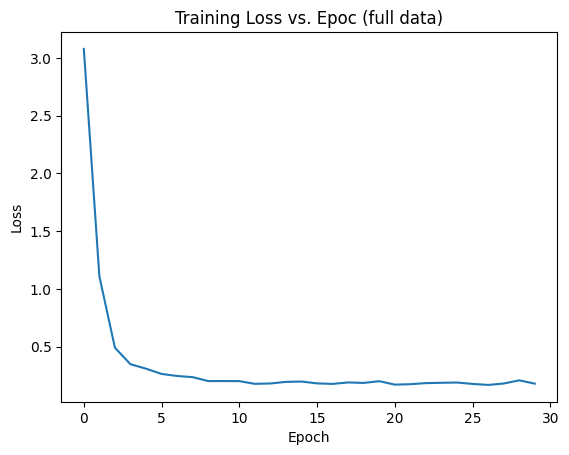

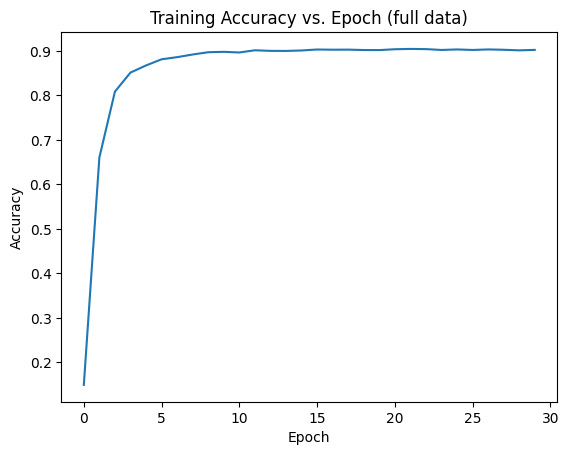

In [ ]:
# plot loss curve and accuracy curve for training
plt.plot(range(KVMem_EPOCH_NUM), averaged_loss_per_epoch)
plt.title("Training Loss vs. Epoc (full data)")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(range(KVMem_EPOCH_NUM), training_accuracy_per_epoch)
plt.title("Training Accuracy vs. Epoch (full data)")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

<ins>**Testing Results:**</ins>
The testing accuracy across 100 testing datasets is 0.72. The implementation of testing is similar to the training loop but with only one epoch. This value of accuracy shows that the model possesses a certain level of generalization capability: 72% of the data it has never seen before are predicted correctly. However, compared to a higher accuracy of 0.90 at epoch 29 for training, this difference of approximately 20% in accuracy indicates that the model still seems to be trying to memorize data during training.

In [ ]:
# testing
print('testing accuracy across 100 test datasets = ', accuracy)

testing accuracy across 100 test datasets =  0.7220190197512801


### **Q3: Report on Model Use**

The technique I used in Part E is to create a function called `parse_question(question)` to parse and structure the original question written in natural language into a question string that could be recognized by the model. Several steps are involved in this approach:

1. Utilize `nltk`'s `ne_chunk()` to tag the entities and obtain their labels in the original question.
2. From the entities:
    - Obtain the person's name (label = `"PERSON"`): the first name and last name should be in a Tree structure from the output of `ne_chunk()`;
    - Extract some adverbs (label = `"WRB"`) such as "where" or "when" and cast these to "place" or "date" to match with our database;
    - Remove the punctuations in the question, where punctuations are entities labeled as `"."`;
    - For certain keywords like "born", "die", or "died", convert these to nouns like "birth" or "death" to match with our database;
    - For other entities such as nouns (e.g., spouse, children, office), no modifications are made. If an entity is not present in our vocabulary, it is marked as unknown;
    - Convert all letters in the question to lowercase.


(Note if the parsed question maintain different order of words like the orignal question, this should not affect the results because we use bag of words when using model.)

Below is an example of the resulting **(name, parsed question) pair** from parsing:

In [333]:
question = "When was Alexander Hamilton born?"
print("(name, parsed question) pair is: ", parse_question(question))

(name, parsed question) pair is:  ('alexander hamilton', 'date was alexander hamilton birth')


After parsing the question, the model is used. The implementation of the function for using the model is very similar to the testing part. First, this person's info is extracted from our datasets (this includes the entire dataset, not only the training and testing data) as keys and values. Then, the parsed question, keys, and values are converted to multi-hot torch tensors and be used as inputs to the model to obtain predictions. The `argmax()` function is then applied to the prediction to obtain the index of the predicted answer in the values. Finally, the answer for the input question should be `values[prediction index]`.

To evaluate the model, I used several types of questions written using natural language to illustrate:

- Test training outcome: Questions regarding a person who exists in the training datasets => e.g., "Thomas Patrick Thornton";
- Test generalization: Questions regarding a person who does not exist in the training and testing datasets. This also means this person does not exist in the vocabulary since our model only took a size of reduced vocabulary => e.g., "Alexander Hamilton";
- Questions with keywords that do not exist in the entire database (DB) but have similar meaning as a known relation in DB. => when using "wife" to represent spouse in orignal question.

1. Person exist in training sets: two examples below

   The predictions are align with the correct answer, this means the model and question parsing technique worked.

In [ ]:
question_2 = "When was Thomas Patrick Thornton born?"
answer = question_anwsering(question_2, DB, KVMem_model, REDUCED_VOCAB_2)
print("output answer from model: ", answer)
print("original value in DB: ", DB["thomas patrick thornton"]["birth date"])

output answer from model:  08 march 1898
original value in DB:  08 march 1898


In [ ]:
question_3 = "Who is Thomas Patrick Thornton's spouse?"
answer = question_anwsering(question_3, DB, KVMem_model, REDUCED_VOCAB_2)
print("output answer from model: ", answer)
print("original value in DB: ", DB["thomas patrick thornton"]["spouse"])

output answer from model:  margaret beaudin thornton rose garland thornton
original value in DB:  margaret beaudin thornton rose garland thornton


2. Person does not exist in training sets, the name does not exist in reduced vocabulary: three examples below asking info of spouse, the start time of the term, and death date.

   The predictions are align with the correct answer, this means the model generalized well and question parsing technique worked since the original questions were written in different phrasing.

In [ ]:
question_2 = "Who is Alexander Hamilton's spouse?"
answer = question_anwsering(question_2, DB, KVMem_model, REDUCED_VOCAB_2)
print("output answer from model: ", answer)
print("original value in DB: ", DB["alexander hamilton"]["spouse"])

output answer from model:  elizabeth schuyler
original value in DB:  elizabeth schuyler


In [ ]:
question_4 = "When did Alexander Hamilton start his term?"
answer = question_anwsering(question_4, DB, KVMem_model, REDUCED_VOCAB_2)
print("output answer from model: ", answer)
print("original value in DB: ", DB["alexander hamilton"]["term start"])

output answer from model:  september 11 1789 december 14 1799 november 3 1788 november 4 1782
original value in DB:  september 11 1789 december 14 1799 november 3 1788 november 4 1782


In [ ]:
question_5 = "Where did Alexander Hamilton die?"
answer = question_anwsering(question_5, DB, KVMem_model, REDUCED_VOCAB_2)
print("output answer from model: ", answer)
print("original value in DB: ", DB["alexander hamilton"]["death place"])

output answer from model:  new york city new york u
original value in DB:  new york city new york u


3. Failure cases: Questions with keywords that do not exist in the entire database (DB) but have similar meaning as a known relation in DB.

    This is an example where the model doesn't work. When using the keyword "wife" in the original question to retrieve information associated with a spouse, the model had a hard time relating "wife" with "spouse" in our database.

    The reason could be that in the training data, the keyword "wife" was never explicitly or implicitly linked to "spouse". The model does not have the capability to recognize and learn the connections between words with similar meanings because there is no such information in the training data. Moreover, during question parsing, I didn't have the chance to implement a mechanism to convert between correlated words (this could be very complicated since there are so many words with similar meanings).

    For future work, one improvement that should be made is to parse the question with the help of large language models such as GPT to achieve better coverage. Alternatively, the database used for training should be augmented: each relation/key could be expanded to a set of keys, where each key is phrased differently using different words but is correlated (with similar meaning).

In [ ]:
# this is an example when model does not work: since during parsing or training, we didn't link wife to spouse.
question_6 = "Who is Alexander Hamilton's wife?"
answer = question_anwsering(question_6, DB, KVMem_model, REDUCED_VOCAB_2)
print("output answer from model: ", answer)
print("original value in DB: ", DB["alexander hamilton"]["spouse"])

output answer from model:  1st united states secretary of the treasury senior officer of the army delegate to the congress of the confederation from new york
original value in DB:  elizabeth schuyler
